<a href="https://colab.research.google.com/github/akshatshah91/Game-AI/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import gym
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings; warnings.simplefilter('ignore')

In [53]:
EPISODES = 5000  # number of episodes
EPS_START = 1  # e-greedy threshold start value
EPS_END = 0.001  # e-greedy threshold end value
EPS_DECAY = 0.995  # e-greedy threshold decay
GAMMA = 0.8  # Q-learning discount factor
LR = 0.001  # NN optimizer learning rate
HIDDEN_LAYER = 256  # NN hidden layer size

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
ByteTensor = torch.ByteTensor
Tensor = FloatTensor

In [6]:
class DQN(nn.Module):
    def __init__(self, inputSize, outputSize, batchSize, learningRate):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(inputSize, HIDDEN_LAYER)
        self.l2 = nn.Linear(HIDDEN_LAYER, outputSize)
        self.memory = []
        self.batchSize = batchSize
        self.inputSize = inputSize
        self.outputSize = outputSize
        self.epsilon = 1
        self.optimizer = optim.Adam(self.parameters(), learningRate)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

    def store(self, transition):
      self.memory.append(transition)

    def act(self, state):
      if random.random() < self.epsilon:
        return LongTensor([[random.randrange(self.outputSize)]])
      else:
        return self(Variable(state).type(FloatTensor)).data.max(1)[1].view(1,1)

    def update(self):
      if len(self.memory) < self.batchSize:
        return
      transitions = random.sample(self.memory, k=self.batchSize)
      state,action,reward,nextState = zip(*transitions)
      state = Variable(torch.cat(state))
      action = Variable(torch.cat(action))
      reward = Variable(torch.cat(reward))
      nextState = Variable(torch.cat(nextState))
      qValues = self(state).gather(1,action)
      maxQValues = self(nextState).detach().max(1)[0]
      expectedQValues = reward + (GAMMA * maxQValues)
      loss = F.smooth_l1_loss(qValues, expectedQValues)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      if self.epsilon > EPS_END:
        self.epsilon *= EPS_DECAY

In [59]:
def train(env, stateSize, actionSize, fig, batchSize, learningRate):
  print("------HYPERPARAMETERS------")
  print("Batch Size =", batchSize)
  print("Learning Rate =", learningRate)
  print("---------------------------")
  agent = DQN(stateSize, actionSize, batchSize, learningRate)
  rewards = []
  avg = []
  ep = []
  for x in range(1, EPISODES+1):
    state = env.reset()
    gameOver = False
    total = 0
    while not gameOver:
      action = agent.act(FloatTensor([state]))
      nextState,reward,gameOver,_ = env.step(action.detach().numpy()[0,0])
      agent.store((FloatTensor([state]), action, FloatTensor([reward]), FloatTensor([nextState])))
      state = nextState
      total += reward
      agent.update()
    rewards.append(total)
    if x % 100 == 0:
      avg.append(sum(rewards)/len(rewards))
      ep.append(x)
  plt.figure(fig)
  plt.xlabel("Episode")
  plt.ylabel("Score")
  plt.plot(ep, avg)
  plt.show()
  label = "Batchsize=" + str(batchSize) + " LR=" + str(learningRate)
  return (ep, avg, label)

------HYPERPARAMETERS------
Batch Size = 10
Learning Rate = 0.001
---------------------------


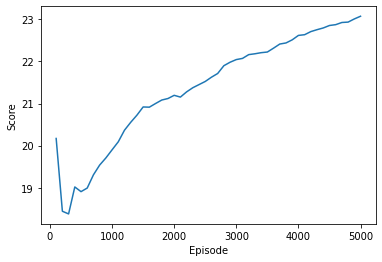

------HYPERPARAMETERS------
Batch Size = 10
Learning Rate = 0.005
---------------------------


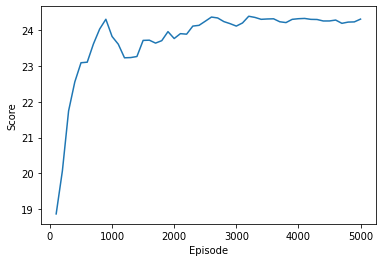

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.001
---------------------------


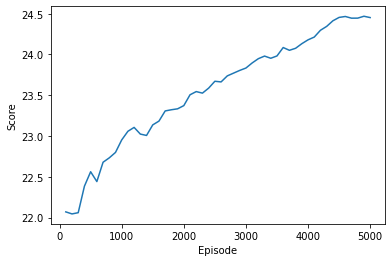

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.005
---------------------------


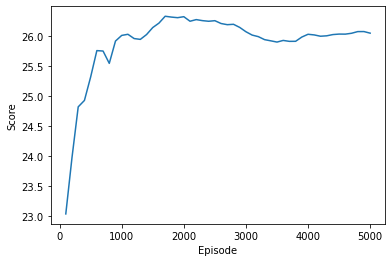

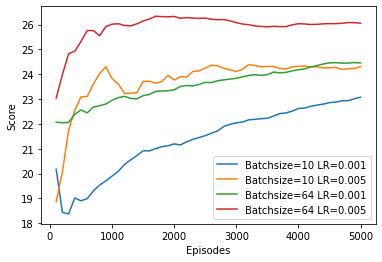

In [61]:
env = gym.make('CartPole-v0').env
stateSize = env.observation_space.shape[0]
actionSize = env.action_space.n
EPISODES = 5000

avgRewards = []
batchSizes = [10, 64]
learningRates = [0.001, 0.005]
x = 1
for b in batchSizes:
  for l in learningRates:
    avgRewards.append(train(env, stateSize, actionSize, x, b, l))
    x += 1

plt.figure(0)
plt.xlabel("Episodes")
plt.ylabel("Score")
for e,a,l in avgRewards:
  plt.plot(e, a, label=l)
plt.legend()

------HYPERPARAMETERS------
Batch Size = 10
Learning Rate = 0.001
---------------------------


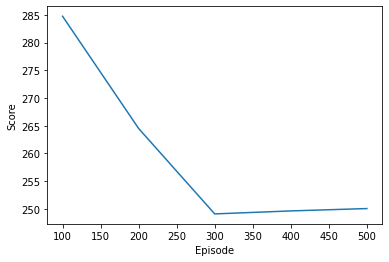

------HYPERPARAMETERS------
Batch Size = 10
Learning Rate = 0.005
---------------------------


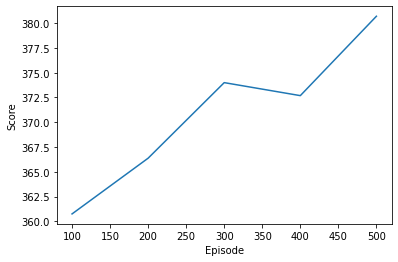

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.001
---------------------------


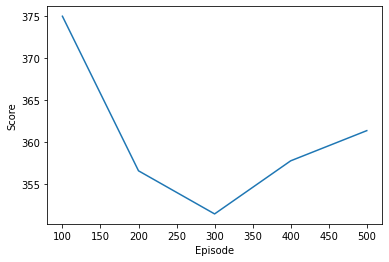

------HYPERPARAMETERS------
Batch Size = 64
Learning Rate = 0.005
---------------------------


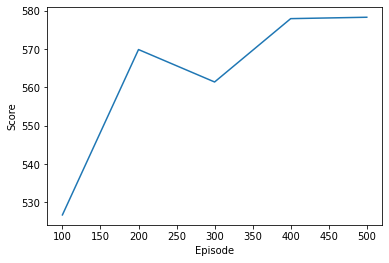

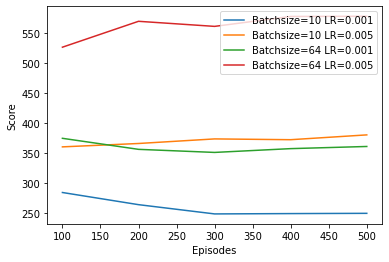

In [62]:
env = gym.make('AirRaid-ram-v0').env
stateSize = env.observation_space.shape[0]
actionSize = env.action_space.n
EPISODES = 500

avgRewards = []
batchSizes = [10, 64]
learningRates = [0.001, 0.005]
x = 1
for b in batchSizes:
  for l in learningRates:
    avgRewards.append(train(env, stateSize, actionSize, x, b, l))
    x += 1

plt.figure(0)
plt.xlabel("Episodes")
plt.ylabel("Score")
for e,a,l in avgRewards:
  plt.plot(e, a, label=l)
plt.legend()